### E-Commerce Predicting Customer Lifetime Value (CLV)

### Background

A firm profits from existing and future customers (a.k.a. Customer Equity). 
Research done by Frederick Reichheld of Bain Company (inventor of NPS score) shows increasing customer retention rates by 5% can increase profits by 25% to 95% (Reichheld 2001).

It is possible to calculate Customer Equity (CE) because Customer Lifetime Value (CLV) can be measured with a reasonable degree of precision. CLV is the present value of the future (net) cash flows associated with the customer (Gupta and Lehmann 2003). It is a forward-looking concept, not to be confused with historic customer profitability.

Not all customers are equally important to a firm. Maintaining long-term relation with all of them (especially the loss makers) is not optimal because eventually marketing is all about attracting and retaining profitable customers (Kotler and Armstrong 1996). Hence the objective of CLV is firstly on general topics of firm’s profitability and secondly as an input in customer acquisition decision and customer acquisition/retention trade-offs (Berger and Nasr 1998).

### Project Goal

The primary goal of this project is to 
- build a probability model to forecast customer lifetime value (CLV) in non-contractual setting on an individual level.
- With the results of this exercise, managers should be able to:
    - Distinguish active/ inactive customers.
    - Generate transaction forecasts for individual customers.
    - Predict the purchase volume of the entire customer base.

In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [378]:
import lifetimes

### 1. Import and Understand Data

In [379]:
customers=pd.read_csv('olist_customers_dataset.csv')
payments=pd.read_csv('olist_order_payments_dataset.csv')
orders=pd.read_csv('olist_orders_dataset.csv')

In [380]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [381]:
customers.shape

(99441, 5)

In [382]:
#customers.columns.values

In [383]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [384]:
payments.shape

(103886, 5)

In [385]:
#payments.columns.values

In [386]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [387]:
orders.shape

(99441, 8)

In [388]:
#orders.columns.values

In [389]:
etrans=orders.merge(customers,how='left',on='customer_id')
etrans=etrans.merge(payments,how='left',on='order_id')

In [390]:
etrans.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


In [391]:
etrans.shape

(103887, 16)

In [392]:
etrans.order_status.value_counts()
#1200/10k=1%

delivered      100757
shipped          1166
canceled          664
unavailable       649
invoiced          325
processing        319
created             5
approved            2
Name: order_status, dtype: int64

In [393]:
df=etrans.loc[etrans.order_status=='delivered']
#surveys_df[surveys_df['species_id'].isin([listGoesHere])]

In [394]:
cols=['customer_id','order_purchase_timestamp','payment_value']
df=df[cols]
df.head()

,customer_id,order_purchase_timestamp,payment_value
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.12
1,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2.00
2,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.59
3,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,141.46
4,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,179.12


In [395]:
df['order_purchase_timestamp']=pd.to_datetime(df['order_purchase_timestamp'])
df['order_purchase_timestamp']=df['order_purchase_timestamp'].dt.date

In [396]:
df=df.rename(columns={'order_purchase_timestamp':'order_date'})

In [397]:
df.head()

,customer_id,order_date,payment_value
0,9ef432eb6251297304e76186b10a928d,2017-10-02,18.12
1,9ef432eb6251297304e76186b10a928d,2017-10-02,2.00
2,9ef432eb6251297304e76186b10a928d,2017-10-02,18.59
3,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,141.46
4,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,179.12


### 2. Explore Data (EDA)

### 2.1 Data Quality Check

#### Check missing values

In [398]:
df.isna().sum()

customer_id      0
order_date       0
payment_value    1
dtype: int64

#### Check duplicates

In [399]:
df.duplicated().sum()

582

#### Check distribution

In [400]:
df.order_date.describe()

count         100757
unique           612
top       2017-11-24
freq            1182
Name: order_date, dtype: object

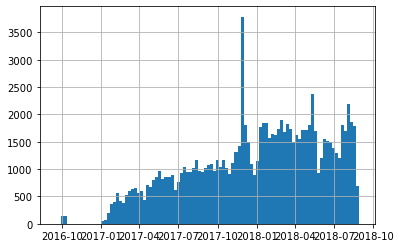

In [401]:
df.order_date.hist(bins=100)

In [402]:
print ("earlist date:", df.order_date.min())
print ("latest date:", df.order_date.max())

earlist date: 2016-09-15
latest date: 2018-08-29


In [408]:
import datetime as dt

In [420]:
today = dt.date(2018,12,31)
df['days']=today - df['order_date']
#df['days'].astype('timedelta64[D]')
df['days']=df['days'] / np.timedelta64(1, 'D')
df.head()

,customer_id,order_date,payment_value,days
0,9ef432eb6251297304e76186b10a928d,2017-10-02,18.12,455.0
1,9ef432eb6251297304e76186b10a928d,2017-10-02,2.00,455.0
2,9ef432eb6251297304e76186b10a928d,2017-10-02,18.59,455.0
3,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,141.46,160.0
4,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,179.12,145.0


In [414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100757 entries, 0 to 103886
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   customer_id    100757 non-null  object 
 1   order_date     100757 non-null  object 
 2   payment_value  100756 non-null  float64
 3   days           100757 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.8+ MB


### 2.2 RFM Matrix

In [421]:
rfm= df.groupby('customer_id').agg({'days': lambda x:x.min(), # Recency
                                    'customer_id': lambda x: len(x),# Frequency
                                    'payment_value': lambda x: x.sum()})# Monetary

rfm.rename(columns={'days': 'recency', 
                    'customer_id': 'frequency', 
                    'payment_value': 'monetary'}, inplace=True)
rfm

,recency,frequency,monetary
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,412.0,1,114.74
000161a058600d5901f007fab4c27140,533.0,1,67.41
0001fd6190edaaf884bcaf3d49edf079,671.0,1,195.42
0002414f95344307404f0ace7a26f1d5,502.0,1,179.35
000379cdec625522490c315e70c7a9fb,273.0,1,107.01
...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,289.0,1,91.91
fffecc9f79fd8c764f843e9951b11341,277.0,3,81.36
fffeda5b6d849fbd39689bb92087f431,223.0,1,63.13


In [ ]:
def summary_data_from_transaction_data(
    transactions,
    customer_id_col,
    datetime_col,
    monetary_value_col=None,
    datetime_format=None,
    observation_period_end=None,
    freq="D",
    freq_multiplier=1,
):

In [443]:
from datetime import date
from datetime import datetime

df['order_date'] =pd.to_datetime(df['order_date'])
df['order_date'].head()

0   2017-10-02
1   2017-10-02
2   2017-10-02
3   2018-07-24
4   2018-08-08
Name: order_date, dtype: datetime64[ns]

In [447]:
summary = summary_data_from_transaction_data(df, 'customer_id', 'order_date', 
                                             monetary_value_col='payment_value',
                                             #datetime_format='yyyy%mm%dd',
                                             observation_period_end='2018-12-31',
                                             freq="D",
                                             freq_multiplier=1,)
summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
00012a2ce6f8dcda20d059ce98491703,0.0,0.0,412.0,0.0
000161a058600d5901f007fab4c27140,0.0,0.0,533.0,0.0
0001fd6190edaaf884bcaf3d49edf079,0.0,0.0,671.0,0.0
0002414f95344307404f0ace7a26f1d5,0.0,0.0,502.0,0.0
000379cdec625522490c315e70c7a9fb,0.0,0.0,273.0,0.0


### 3. Modeling: MBG/NBD

Model assumptions:

- While active, # transactions made by a customer follows a Poisson process with transaction rate λ .
- Heterogeneity in λ across customers follows a Gamma distribution with shape parameter r and scale parameter α .
- At time zero and right after each purchase the customer becomes inactive with a constant probability p .
- Heterogeneity in p across customers follows a Gamma distribution with parameter a and b .
- The transaction rate λ and the dropout probability p vary independently across customers.

In [417]:
from lifetimes import ModifiedBetaGeoFitter
bgf=ModifiedBetaGeoFitter(penalizer_coef=0.01)

bgf.fit(rfm['frequency'],
        rfm['recency'],
        rfm['monetary'],
        verbose=True)

#### Cross-Validation

In [419]:
summary_cal_holdout = calibration_and_holdout_data(df, 'customer_id','order_date',
                                                   
                                        calibration_period_end='2017-09-15',
                                        observation_period_end='2018-8-29' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
000161a058600d5901f007fab4c27140,0.0,0.0,61.0,0.0,348.0
0001fd6190edaaf884bcaf3d49edf079,0.0,0.0,199.0,0.0,348.0
0002414f95344307404f0ace7a26f1d5,0.0,0.0,30.0,0.0,348.0
0004164d20a9e969af783496f3408652,0.0,0.0,156.0,0.0,348.0
00062b33cb9f6fe976afdcff967ea74d,0.0,0.0,184.0,0.0,348.0


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


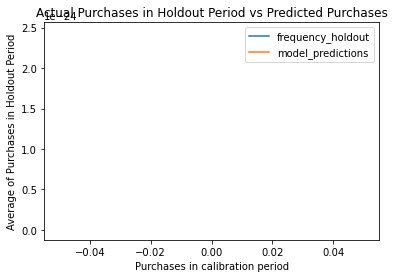

In [367]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
        verbose=True)

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
#why pic not showing?

In [165]:
from lifetimes.plotting import plot_frequency_recency_matrix

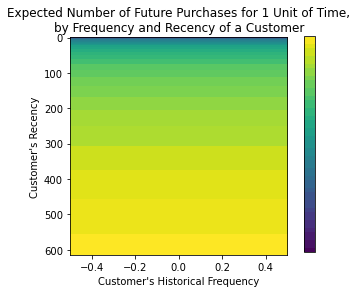

In [166]:
plot_frequency_recency_matrix(bgf)

In [ ]:
#plot_probability_alive_matrix(bgf)

#### Predictions for each customer

In [75]:
t=30
rfm['predicted_purchases']=bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                  rfm['frequency'],
                                                                                  rfm['recency'],
                                                                                  rfm['T'])

In [76]:
rfm.head()

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
00012a2ce6f8dcda20d059ce98491703,0.0,0.0,288.0,0.0,5.825053e-26
000161a058600d5901f007fab4c27140,0.0,0.0,409.0,0.0,4.087756e-26
0001fd6190edaaf884bcaf3d49edf079,0.0,0.0,547.0,0.0,3.065817e-26
0002414f95344307404f0ace7a26f1d5,0.0,0.0,378.0,0.0,4.394338e-26
000379cdec625522490c315e70c7a9fb,0.0,0.0,149.0,0.0,1.113914e-25


In [77]:
rfm['p_alive'] = bgf.conditional_probability_alive(rfm['frequency'], rfm['recency'], rfm['T'])
rfm['p_alive'] = np.round(rfm['p_alive'] / rfm['p_alive'].max(), 2)

In [78]:
rfm.head()

,frequency,recency,T,monetary_value,predicted_purchases,p_alive
customer_id,,,,,,
00012a2ce6f8dcda20d059ce98491703,0.0,0.0,288.0,0.0,5.825053e-26,1.0
000161a058600d5901f007fab4c27140,0.0,0.0,409.0,0.0,4.087756e-26,1.0
0001fd6190edaaf884bcaf3d49edf079,0.0,0.0,547.0,0.0,3.065817e-26,1.0
0002414f95344307404f0ace7a26f1d5,0.0,0.0,378.0,0.0,4.394338e-26,1.0
000379cdec625522490c315e70c7a9fb,0.0,0.0,149.0,0.0,1.113914e-25,1.0


### Model Evaluation